In [19]:
# -*- coding: utf-8 -*-
"""This module defines functions for Dali searching Protein Data Bank."""

import re
import numpy as np
from prody.atomic import Atomic, AtomGroup, AtomMap
from prody.proteins.pdbfile import _getPDBid
from prody.measure import getRMSD, getTransformation
from prody.utilities import checkCoords, checkWeights, createStringIO
from prody import LOGGER, PY3K
from prody import parsePDB, writePDBStream
# if PY3K:
    # import urllib.parse as urllib
    # import urllib.request as urllib2
# else:
    # import urllib
    # import urllib2
from prody.ensemble import Ensemble
from prody.ensemble import PDBEnsemble
import os

__all__ = ['DaliRecord', 'searchDali', 
           'daliFilterMultimer', 'daliFilterMultimers']

def searchDal(pdb, chain=None, subset='fullPDB', daliURL=None, **kwargs):
    """Search Dali server with input of PDB ID (or local PDB file) and chain ID.
    Dali server: http://ekhidna2.biocenter.helsinki.fi/dali/
    
    :arg pdb: PDB code or local PDB file for the protein to be searched

    :arg chain: chain identifier (only one chain can be assigned for PDB)
    :type chain: str

    :arg subset: fullPDB, PDB25, PDB50, PDB90
    :type subset: str
    """
    
    import requests
    
    LOGGER.timeit('_dali')
    # timeout = 120
    timeout = kwargs.pop('timeout', 120)
    
    if daliURL is None:
        daliURL = "http://ekhidna2.biocenter.helsinki.fi/cgi-bin/sans/dump.cgi"
    
    if isinstance(pdb, Atomic):
        atoms = pdb
        chain_set = set(atoms.getChids())
        if chain and not chain in chain_set:
            raise ValueError('input structure (%s) does not have chain %s'%(atoms.getTitle(), chain))
        
        if len(chain_set) > 1:
            if not chain:
                raise TypeError('the structure (%s) contains more than one chain, therefore a chain identifier '
                                'needs to be specified'%pdb.getTitle())
            atoms = atoms.select('chain '+chain)
        else:
            chain = chain_set.pop()
            
        stream = createStringIO()
        writePDBStream(stream, atoms)
        data = stream.getvalue()
        stream.close()
        files = {"file1" : data}

        pdbId = atoms.getTitle()
        pdb_chain = ''
        dali_title = 'Title_'+pdbId+chain
    elif isinstance(pdb, str):
        if os.path.isfile(pdb):
            atoms = parsePDB(pdb)
            chain_set = set(atoms.getChids())
            # pdbId = "s001"
            filename = os.path.basename(pdb)
            filename, ext = os.path.splitext(filename)
            if ext.lower() == '.gz':
                filename2, ext2 = os.path.splitext(filename)
                if ext2.lower() == '.pdb':
                    filename = filename2
            pdbId = filename
            if chain and not chain in chain_set:
                raise ValueError('input PDB file does not have chain ' + chain)
            
            if len(chain_set) > 1:
                if not chain:
                    raise TypeError('PDB file (%s) contains more than one chain, therefore a chain identifier '
                                    'needs to be specified'%pdb)
                atoms = atoms.select('chain '+chain)
                #local_temp_pdb = pdbId+chain+'.pdb'
                #local_temp_pdb = 's001'+chain+'.pdb'
                stream = createStringIO()
                writePDBStream(stream, atoms)
                data = stream.getvalue()
                stream.close()
            else:
                data = open(pdb, "rb")
                chain = chain_set.pop()
            files = {"file1" : data}
            # case: multiple chains.             apply fetch ? multiple times?
            pdb_chain = ''
            dali_title = 'Title_' + pdbId + chain
        else:
            pdbId, ch = _getPDBid(pdb)
            if not chain:
                chain = ch
            if not chain:
                raise TypeError('a chain identifier is needed for the search')
            pdb_chain = pdbId + chain
            dali_title = 'Title_' + pdb_chain
            files = ''
    parameters = { 'cd1' : pdb_chain, 'method': 'search', 'title': dali_title, 'address': '' }
    # enc_params = urllib.urlencode(parameters).encode('utf-8')
    # request = urllib2.Request(daliURL, enc_params)
    request = requests.post(daliURL, parameters, files=files)
    try_error = 3
    while try_error >= 0:
        try:
            # url = urllib2.urlopen(request).url
            url = request.url
            break
        except:
            try_error -= 1
            if try_error >= 0:
                LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                continue
            else:
                # url = urllib2.urlopen(request).url
                url = request.url
                break
    if url.split('.')[-1].lower() in ['html', 'php']:
        # print('test -1: '+url)
        url = url.replace(url.split('/')[-1], '')
    LOGGER.debug('Submitted Dali search for PDB "{0}{1}".'.format(pdbId, chain))
    LOGGER.info(url)
    LOGGER.clear()
    
    return DaliRecor(url, pdbId, chain, subset=subset, timeout=timeout, **kwargs)
    

class DaliRecor(object):

    """A class to store results from Dali PDB search."""

    def __init__(self, url, pdbId, chain, subset='fullPDB', localFile=False, **kwargs):
        """Instantiate a DaliRecord object instance.

        :arg url: url of Dali results page or local dali results file
        :arg pdbId: PDB code for searched protein
        :arg chain: chain identifier (only one chain can be assigned for PDB)
        :arg subset: fullPDB, PDB25, PDB50, PDB90. Ignored if localFile=True (url is a local file)
        :arg localFile: whether provided url is a path for a local dali results file
        """

        self._url = url
        self._pdbId = pdbId
        self._chain = chain
        subset = subset.upper()
        if subset == "FULLPDB" or subset not in ["PDB25", "PDB50", "PDB90"]:
            self._subset = ""
        else:
            self._subset = "-"+subset[3:]
        timeout = kwargs.pop('timeout', 120)

        self._title = pdbId + '-' + chain
        self._alignPDB = None
        self._filterDict = None
        self._max_index = None
        self.fetch(self._url, localFile=localFile, timeout=timeout, **kwargs)

    def fetch(self, url=None, localFile=False, **kwargs):
        """Get Dali record from url or file.

        :arg url: url of Dali results page or local dali results file
            If None then the url already associated with the DaliRecord object is used.
        :type url: str

        :arg localFile: whether provided url is a path for a local dali results file
        :type localFile: bool

        :arg timeout: amount of time until the query times out in seconds
            default value is 120
        :type timeout: int

        :arg localfolder: folder in which to find the local file
            default is the current folder
        :type localfolder: str
        """
        if localFile:
            dali_file = open(url, 'r')
            data = dali_file.read()
            dali_file.close()
        else:
            import requests
            
            if url == None:
                url = self._url
            
            sleep = 2
            timeout = kwargs.pop('timeout', 120)
            LOGGER.timeit('_dali')
            log_message = ''
            try_error = 3
            while True:
                LOGGER.write('Connecting to Dali for search results...')
                LOGGER.clear()
                try:
                    # html = urllib2.urlopen(url).read()
                    html = requests.get(url).content
                except:
                    try_error -= 1
                    if try_error >= 0:
                        LOGGER.sleep(2, '. Connection error happened. Trying to reconnect...')
                        continue
                    else:
                        # html = urllib2.urlopen(url).read()
                        html = requests.get(url).content
                if PY3K:
                    html = html.decode()
                if html.find('Status: Queued') > -1:
                    log_message = '(Dali search is queued)...'
                elif html.find('Status: Running') > -1:
                    log_message = '(Dali search is running)...'
                elif html.find('Your job') == -1 and html.find('.txt') > -1:
                    break
                elif html.find('ERROR:') > -1:
                    LOGGER.warn(': Dali search reported an ERROR!')
                    self.isSuccess = False
                    return False
                sleep = 20 if int(sleep * 1.5) >= 20 else int(sleep * 1.5)
                if LOGGER.timing('_dali') > timeout:
                    LOGGER.warn(': Dali search has timed out. \nThe results can be obtained later using the fetch() method.')
                    self.isSuccess = False
                    return False
                LOGGER.sleep(int(sleep), 'to reconnect to Dali '+log_message)
                LOGGER.clear()
            LOGGER.clear()
            LOGGER.report('Dali results were fetched in %.1fs.', '_dali')
            lines = html.strip().split('\n')
            file_name = re.search('=.+-90\\.txt', html).group()[1:]
            file_name = file_name[:-7]
            # LOGGER.info(url+file_name+self._subset+'.txt')
            # data = urllib2.urlopen(url+file_name+self._subset+'.txt').read()
            data = requests.get(url+file_name+self._subset+'.txt').content
            if PY3K:
                data = data.decode()
            localfolder = kwargs.pop('localfolder', '.')

            if file_name.lower().startswith('s001'):
                temp_name = self._pdbId + self._chain
            else:
                temp_name = file_name
            temp_name += self._subset + '_dali.txt'
            if localfolder != '.' and not os.path.exists(localfolder):
                os.mkdir(localfolder)
            with open(localfolder+os.sep+temp_name, "w") as file_temp: file_temp.write(html + '\n' + url+file_name+self._subset+'.txt' + '\n' + data)
            # with open(temp_name, "a+") as file_temp: file_temp.write(url+file_name + '\n' + data)
        data_list = data.strip().split('# ')
        # No:  Chain   Z    rmsd lali nres  %id PDB  Description -> data_list[3]
        # Structural equivalences -> data_list[4]
        # Translation-rotation matrices -> data_list[5]
        map_temp_dict = dict()
        lines = data_list[4].strip().split('\n')
        self._lines_4 = lines
        mapping_temp = np.genfromtxt(lines[1:], delimiter = (4,1,14,6,2,4,4,5,2,4,4,3,5,4,3,5,6,3,5,4,3,5,28), 
                                     usecols = [0,3,5,7,9,12,15,15,18,21], dtype='|i4')
        # [0,3,5,7,9,12,15,15,18,21] -> [index, residue_a, residue_b, residue_i_a, residue_i_b, resid_a, resid_b, resid_i_a, resid_i_b]
        for map_i in mapping_temp:
            if not map_i[0] in map_temp_dict:
                map_temp_dict[map_i[0]] = [[map_i[1], map_i[2], map_i[3], map_i[4]]]
            else:
                map_temp_dict[map_i[0]].append([map_i[1], map_i[2], map_i[3], map_i[4]])
        self._max_index = max(mapping_temp[:,2])
        self._mapping = map_temp_dict
        self._data = data_list[3]
        lines = data_list[3].strip().split('\n')
        # daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                # dtype=[('id', '<i4'), ('pdb_chain', '|S6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                # ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|S70')])
        daliInfo = np.genfromtxt(lines[1:], delimiter = (4,3,6,5,5,5,6,5,57), usecols = [0,2,3,4,5,6,7,8], 
                                dtype=[('id', '<i4'), ('pdb_chain', '|U6'), ('Z', '<f4'), ('rmsd', '<f4'), 
                                ('len_align', '<i4'), ('nres', '<i4'), ('identity', '<i4'), ('title', '|U70')])
        if daliInfo.ndim == 0:
            daliInfo = np.array([daliInfo])
        pdbListAll = []
        self._daliInfo = daliInfo
        dali_temp_dict = dict()
        for temp in self._daliInfo:
            temp_dict = dict()
            pdb_chain = temp[1].strip()[0:6]
            # U6 and U70 were used as the dtype for np.genfromtext -> unicode string were used in daliInfo 
            # if PY3K:
                # pdb_chain = pdb_chain.decode()
            pdb_chain = str(pdb_chain)
            temp_dict['pdbId'] = pdbid = pdb_chain[0:4].lower()
            temp_dict['chainId'] = chid = pdb_chain[5:6]
            temp_dict['pdb_chain'] = pdb_chain = pdbid + chid
            temp_dict['Z'] = temp[2]
            temp_dict['rmsd'] = temp[3]
            temp_dict['len_align'] = temp[4]
            temp_dict['nres'] = temp[5]
            temp_dict['identity'] = temp[6]
            temp_dict['mapping'] = (np.array(map_temp_dict[temp[0]])-1).tolist()
            temp_dict['map_ref'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[0], map_i[1]+1)]
            temp_dict['map_sel'] = [x for map_i in (np.array(map_temp_dict[temp[0]])-1).tolist() for x in range(map_i[2], map_i[3]+1)]
            dali_temp_dict[pdb_chain] = temp_dict
            pdbListAll.append(pdb_chain)
        self._pdbListAll = tuple(pdbListAll)
        self._pdbList = self._pdbListAll
        self._alignPDB = dali_temp_dict
        LOGGER.info('Obtained ' + str(len(pdbListAll)) + ' PDB chains from Dali for '+self._pdbId+self._chain+'.')
        self.isSuccess = True
        return True
        
    def getPDBs(self, filtered=True):
        """Returns PDB list (filters may be applied)"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
        
        if filtered:
            return self._pdbList
        return self._pdbListAll
        
    def getHits(self):
        """Returns the dictionary associated with the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')

        return self._alignPDB
        
    def getFilterList(self):
        """Returns a list of PDB IDs and chains for the entries that were filtered out"""
        
        filterDict = self._filterDict
        if filterDict is None:
            raise ValueError('You cannot obtain the list of filtered out entries before doing any filtering.')

        temp_str = ', '.join([str(len(filterDict['len'])), str(len(filterDict['rmsd'])), 
                            str(len(filterDict['Z'])), str(len(filterDict['identity']))])
        LOGGER.info('Filtered out [' + temp_str + '] for [length, RMSD, Z, identity]')
        return self._filterList

    
    def getMapping(self, key):
        """Get mapping for a particular entry in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None
        
        try:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
        except KeyError:
            return None
        return mapping

    def getMappings(self):
        """Get all mappings in the DaliRecord"""

        if self._alignPDB is None:
            LOGGER.warn('Dali Record does not have any data yet. Please run fetch.')
            return None

        map_dict = {}
        for key in self._alignPDB:
            info = self._alignPDB[key]
            mapping = [info['map_ref'], info['map_sel']]
            map_dict[key] = mapping
        return map_dict

    mappings = property(getMappings)

    def filter(self, cutoff_len=None, cutoff_rmsd=None, cutoff_Z=None, cutoff_identity=None):
        """Filters out PDBs from the PDBList and returns the PDB list.
        PDBs that satisfy any of the following criterion will be filtered out.
        (1) Length of aligned residues < cutoff_len (must be an integer or a float between 0 and 1);
        (2) RMSD < cutoff_rmsd (must be a positive number);
        (3) Z score < cutoff_Z (must be a positive number);
        (4) Identity > cutoff_identity (must be an integer or a float between 0 and 1).
        """
        if self._max_index is None:
            LOGGER.warn('DaliRecord has no data. Please use the fetch() method.')
            return None

        if cutoff_len == None:
            # cutoff_len = int(0.8*self._max_index)
            cutoff_len = 0.00000001
        elif not isinstance(cutoff_len, (float, int)):
            raise TypeError('cutoff_len must be a float or an integer')
        elif cutoff_len <= 1 and cutoff_len > 0:
            cutoff_len = int(cutoff_len*self._max_index)
        elif cutoff_len <= self._max_index and cutoff_len > 0:
            cutoff_len = int(cutoff_len)
        else:
            raise ValueError('cutoff_len must be a float between 0 and 1, or an int not greater than the max length')
            
        if cutoff_rmsd == None:
            cutoff_rmsd = 1000
        elif not isinstance(cutoff_rmsd, (float, int)):
            raise TypeError('cutoff_rmsd must be a float or an integer')
        elif cutoff_rmsd >= 0:
            cutoff_rmsd = float(cutoff_rmsd)
        else:
            raise ValueError('cutoff_rmsd must be a number not less than 0')
            
        if cutoff_Z == None:
            cutoff_Z = 0
        elif not isinstance(cutoff_Z, (float, int)):
            raise TypeError('cutoff_Z must be a float or an integer')
        elif cutoff_Z >= 0:
            cutoff_Z = float(cutoff_Z)
        else:
            raise ValueError('cutoff_Z must be a number not less than 0')
            
        if cutoff_identity == None or cutoff_identity == 0:
            cutoff_identity = 0
        elif not isinstance(cutoff_identity, (float, int)):
            raise TypeError('cutoff_identity must be a float or an integer')
        elif cutoff_identity <= 1 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity*100)
        elif cutoff_identity <= 100 and cutoff_identity > 0:
            cutoff_identity = float(cutoff_identity)
        else:
            raise ValueError('cutoff_identity must be a float between 0 and 1, or a number between 0 and 100')
            
        # debug:
        # print('cutoff_len: ' + str(cutoff_len) + ', ' + 'cutoff_rmsd: ' + str(cutoff_rmsd) + ', ' + 'cutoff_Z: ' + str(cutoff_Z) + ', ' + 'cutoff_identity: ' + str(cutoff_identity))
        
        daliInfo = self._alignPDB
        if daliInfo is None:
            raise ValueError("Dali Record does not have any data yet. Please run fetch.")

        pdbListAll = self._pdbListAll
        missing_ind_dict = dict()
        ref_indices_set = set(range(self._max_index))
        filterListLen = []
        filterListRMSD = []
        filterListZ = []
        filterListIdentity = []
        
        RMSDs = []
        
        # keep the first PDB (query PDB)
        for pdb_chain in pdbListAll[1:]:
            temp_dict = daliInfo[pdb_chain]
            # print ('currRMSD', temp_dict['rmsd'])
            # filter: len_align, identity, rmsd, Z
            RMSDs.append(temp_dict['rmsd'])
            if temp_dict['len_align'] < cutoff_len:
                # print('Filter out ' + pdb_chain + ', len_align: ' + str(temp_dict['len_align']))
                filterListLen.append(pdb_chain)
                continue
            if temp_dict['rmsd'] > cutoff_rmsd:
                # print('Filter out ' + pdb_chain + ', rmsd: ' + str(temp_dict['rmsd']))
                filterListRMSD.append(pdb_chain)
                # print ('currRMSD', temp_dict['rmsd'])
                # print(pdb_chain)
                continue
            if temp_dict['Z'] < cutoff_Z:
                # print('Filter out ' + pdb_chain + ', Z: ' + str(temp_dict['Z']))
                filterListZ.append(pdb_chain)
                continue
            if temp_dict['identity'] < cutoff_identity:
                # print('Filter out ' + pdb_chain + ', identity: ' + str(temp_dict['identity']))
                filterListIdentity.append(pdb_chain)
                continue
            temp_diff = list(ref_indices_set - set(temp_dict['map_ref']))
            for diff_i in temp_diff:
                if not diff_i in missing_ind_dict:
                    missing_ind_dict[diff_i] = 1
                else:
                    missing_ind_dict[diff_i] += 1
        self._missing_ind_dict = missing_ind_dict
        
        filterList = filterListLen + filterListRMSD + filterListZ + filterListIdentity
        filterDict = {'len': filterListLen, 'rmsd': filterListRMSD, 'Z': filterListZ, 'identity': filterListIdentity}
        self._filterList = filterList
        self._filterDict = filterDict
        self._pdbList = [self._pdbListAll[0]] + [item for item in self._pdbListAll[1:] if not item in filterList]
        LOGGER.info(str(len(filterList)) + ' PDBs have been filtered out from '+str(len(pdbListAll))+' Dali hits (remaining: '+str(len(pdbListAll)-len(filterList))+').')
        
        filterRMSD = []
        diverseRMSD = []
        for item in RMSDs:
            if item < cutoff_rmsd:
                filterRMSD.append(item)
            if item > 1.0:
                diverseRMSD.append(item)
        
        print ('RMSD less than ', cutoff_rmsd, mean(filterRMSD), std(filterRMSD))
        print ('RMSD greater than 1A ', mean(diverseRMSD), std(diverseRMSD))
        
        return self._pdbList
    
    def getTitle(self):
        """Return the title of the record"""

        return self._title

def daliFilterMultimer(atoms, dali_rec, n_chains=None):
    """
    Filters multimers to only include chains with Dali mappings.

    :arg atoms: the multimer to be filtered
    :type atoms: :class:`.Atomic`

    :arg dali_rec: the DaliRecord object with which to filter chains
    :type dali_rec: :class:`.DaliRecord`
    """
    if not isinstance(atoms, Atomic):
        raise TypeError("atoms should be an Atomic object")

    if not isinstance(dali_rec, DaliRecord):
        raise TypeError("dali_rec should be a DaliRecord")
    try:
        keys = dali_rec._alignPDB
    except:
        raise AttributeError("Dali Record does not have any data yet. Please run fetch.")

    numChains = 0
    atommap = None
    for i, chain in enumerate(atoms.iterChains()):
        m = dali_rec.getMapping(chain.getTitle()[:4] + chain.getChid())
        if m is not None:
            numChains += 1
            if atommap is None:
                atommap = chain
            else:
                atommap += chain

    if n_chains is None or numChains == n_chains:
        return atommap
    else:
        return None

def daliFilterMultimers(structures, dali_rec, n_chains=None):
    """A wrapper for daliFilterMultimer to apply to multiple structures.
    """
    dali_ags = []
    for entry in structures:
        result = daliFilterMultimer(entry, dali_rec, n_chains)
        if result is not None:
            dali_ags.append(result)
    return dali_ags

In [20]:
from numpy import *
from matplotlib.pyplot import *
# import os
ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals

def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    
    flat = flattenData(FinalRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return FinalRegions, final_values

def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = np.sqrt(np.sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = np.sqrt(np.sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDal(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = eigVals[0]

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge


def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [21]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total

import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')

In [22]:
def screenIDs(ids):
    newIDs = []
    for item in ids:
        newIDs.append(item[:4])
    return newIDs

# filter transmembrane protein
def filterHinges(Hinges_2, ContinueThreshold = 50, HingeCutoff = 10):
    newHinges = []
    currItem = []
    for item in Hinges_2:
        if currItem == [] or currItem[-1] == item - 1:
            currItem.append(item)
        else:
            newHinges.append(currItem)
            currItem = []

    filteredItem = []
    for item in newHinges:
        if len(item) <= ContinueThreshold:
            filteredItem += item
        else:
            filteredItem += item[:HingeCutoff]
            filteredItem += item[-HingeCutoff:]
    return filteredItem 

In [23]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

In [24]:
def trimEnds(values, lists, Number):
    begining = Number
    ends = len(values) - Number
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions


In [25]:
def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals


In [799]:
testList = [[11, 12], [27], [32, 33], [35], [38], [43, 44], [66], [69, 70], [72, 73, 74], [76], [110], [113], [117], [119], [121], [123], [125, 126, 127], [129], [140], [143], [149], [167], [194, 195, 196], [233, 234, 235, 236]]
[[11, 12], [27], [32, 33, 35, 38], [43, 44], [66, 69, 70, 72, 73, 74, 76], [110, 113], [117, 119, 121, 123, 125, 126, 127, 129], [140, 143], [149], [167], [194, 195, 196], [233, 234, 235, 236]]
print ('test', testList)
afterMerge = mergeRegions(testList)
print ('merging', afterMerge)


test [[11, 12], [27], [32, 33], [35], [38], [43, 44], [66], [69, 70], [72, 73, 74], [76], [110], [113], [117], [119], [121], [123], [125, 126, 127], [129], [140], [143], [149], [167], [194, 195, 196], [233, 234, 235, 236]]
merging [[11, 12], [27], [32, 33], [35], [38], [43, 44], [66, 69, 70, 72, 73, 74, 76], [110], [113], [117, 119, 121, 123, 125, 126, 127, 129], [140], [143], [149], [167], [194, 195, 196], [233, 234, 235, 236]]


In [8]:
# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

In [1004]:
test_trimValues = averageEigVects[:, 1]
test_regions = [[0, 1, 2, 3, 4, 5, 6, 7], [14, 15], [30, 31, 32, 33, 34], [74, 75], [136, 137], [163, 164],[195, 196, 197, 198, 199, 200, 201, 202, 203], [242, 243]]

currIndex = [0, 1, 2, 3, 4, 5, 6, 7]
values = [test_trimValues[x] for x in currIndex]
print (currIndex, values)

# Apply the trimming functions
trimmed_start, trimmed_index = trim_start(values, currIndex)
print (trimmed_index)
trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)

print (trimmed_index)

[0, 1, 2, 3, 4, 5, 6, 7] [-0.012145844053075878, 0.006311074484731963, 0.008204660752803135, -0.009002312279149105, 0.008667780867307696, 0.024432445851166287, 0.02095324867314582, 0.008715464453547627]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4]


In [1005]:
trimmedRegions_test = trimRegions(test_regions, test_trimValues)
trimmedRegions_test 

[0, 1, 2, 3, 4, 5, 6, 7] [-0.012145844053075878, 0.006311074484731963, 0.008204660752803135, -0.009002312279149105, 0.008667780867307696, 0.024432445851166287, 0.02095324867314582, 0.008715464453547627]
[14, 15] [0.00480563815128272, -0.005954714022040934]
[30, 31, 32, 33, 34] [-0.0027435367420722764, 0.0031246304164741193, -0.0024551519475485856, -0.0014855766796718595, 0.01683868814142116]
[74, 75] [0.00625772345133555, -0.013193548302112262]
[136, 137] [-0.012789727355049137, 0.0092583754821141]
[163, 164] [0.007240227962830829, -0.012704610978925019]
[195, 196, 197, 198, 199, 200, 201, 202, 203] [-0.01891735126211273, 0.0012675118268159157, -0.013602714395948134, -0.017128697214942132, 0.0017994570753776808, 0.0077044913487170465, -0.004574498226751858, -0.0027065596685708565, 0.022033778770044143]
[242, 243] [0.025455831043307276, -0.005357246137885624]


[[0, 1, 2, 3, 4],
 [14, 15],
 [30, 31, 32, 33, 34],
 [74, 75],
 [136, 137],
 [163, 164],
 [195, 196, 197, 198, 199, 200, 201, 202, 203],
 [242, 243]]

In [9]:
def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    # print ('filtering_pairs', crossoverPoints_pairs)
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs


In [1124]:
round(0.50001)

1

In [10]:
def filteringCriteria(Final, values, crossovers):
    FinalRegions = []
    for region in Final:
        # print ('before filtering', region)
        if len(region) >= 3:
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - 2) / 4 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        # elif 3 <= len(region) == 4:
            # region = find_cross_points(region, crossovers, values)
            # print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif len(region) == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

In [1219]:
values[:5]

array([-0.08031129, -0.09027627, -0.06144799, -0.05256615, -0.07993942])

In [1220]:
Final = [[106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 125, 126, 127]]
values = averageEigVects[:, 2]
crossovers = [30, 31, 34, 35, 63, 74, 75, 77, 107, 110, 111, 113, 115, 117, 119, 120, 126, 127, 140, 142, 143, 150, 168]


In [1221]:
len(Final[0])

19

In [1222]:
filteringCriteria(Final, values, crossovers)

[[118, 119, 113, 110, 114, 116]]

In [11]:
def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    # print ('debug regions, hinges', regions, hinges)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    # trim Regions
    trimmedFinal = trimRegions(Final, values)
    # rint ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 15):
            updateRegions.append(currReg)
    
    # print ('trim tails', updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [12]:
def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [1258]:
mode2 = averageEigVects[:, 2]
mode2[194:198]

array([0.04196466, 0.03380264, 0.04152289, 0.05277437])

In [1226]:
mode2[106:128]

array([-1.83053235e-02,  4.52003597e-03,  1.71342222e-02,  1.43388754e-02,
       -5.63458962e-04,  1.57163591e-02,  2.45798633e-02, -4.67420014e-05,
       -5.79286594e-04,  1.53799344e-02,  1.28913970e-03, -8.55164006e-03,
       -3.26336407e-03,  1.38373165e-04, -1.18484750e-02, -1.06797031e-02,
       -3.04178658e-03, -7.39488299e-03, -1.37847874e-02, -1.04042342e-02,
        2.58063991e-03, -1.40831155e-02])

In [1227]:
FinalRegions, vals = oneModeHinge_update2(mode2, Hinge2, thereshold=15)

crossovers [30, 31, 34, 35, 63, 74, 75, 77, 107, 110, 111, 113, 115, 117, 119, 120, 126, 127, 140, 142, 143, 150, 168]
extend Regions [[29, 30, 31], [33, 34, 35], [62, 63], [73, 74, 75, 76, 77], [106, 107], [109, 110, 111], [112, 113, 114, 115, 116, 117, 118, 119, 120], [125, 126, 127], [139, 140, 141, 142, 143], [149, 150], [167, 168]]
before merging [[27], [29, 30, 31, 32, 33, 34, 35], [38], [62, 63], [66], [73, 74, 75, 76, 77], [106, 107], [109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121], [123], [125, 126, 127], [129], [139, 140, 141, 142, 143], [149, 150], [167, 168]]
Final is [[27, 29, 30, 31, 32, 33, 34, 35, 38], [62, 63], [66], [73, 74, 75, 76, 77], [106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 125, 126, 127, 129], [139, 140, 141, 142, 143], [149, 150], [167, 168]]
after trimming [[29, 30, 31, 32, 33, 34, 35], [62, 63], [66], [73, 74, 75, 76, 77], [106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 

In [1179]:
print (sort(calcHinges(gnm[0])))

[ 11  44  70  72  73 123 125 197 232]


In [82]:
def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 4:
            if len(region) == 4:
                if values[region[0]-1] * values[region[-1]+1] > 0:
                    continue  
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif  len(region) == 3:  
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
            else:
                region = find_cross_points(region, crossovers, values)

        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg, 15):
            updateRegions.append(currReg)
    
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [83]:
# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]], trimmingLength = 15):
    FilteringIndex = []
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

In [159]:
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')

# Similar ensemble

In [186]:
currPDB = '1ea1'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
EigVals, averageEigVects, ids, gnms, averageEigVects = getModes(currPDB, eachChain, length=0.8, rmsd=2, Z=10)


@> Submitted Dali search for PDB "1ea1A".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//1ea1A/
@> Dali results were fetched in 0.2s.   
@> Obtained 2025 PDB chains from Dali for 1ea1A.
@> 2011 PDBs have been filtered out from 2025 Dali hits (remaining: 14).
@> Retrieving 1ea1A... [  0%]

RMSD less than  2.0 0.8538462 0.40689325
RMSD greater than 1A  3.735186 0.4253011
# of similar structures is found from Dali 14


@> 14 PDBs were parsed in 4.44s. 
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 8.2499e-01
@> Step #2: RMSD difference = 8.3951e-03
@> Step #3: RMSD difference = 3.4448e-04
@> Step #4: RMSD difference = 1.5459e-05
@> Iterative superposition completed in 0.02s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.00 seconds.
@> Ensemble (14 conformations) were built in 0.60s.
@> WARNING last 28 modes for 418 modes from MaskedGNM 1ea1A_ca reduced has been discarded because at least one conformation has only 418 modes
@> WARNING last 28 modes for 418 modes from MaskedGNM 1e9xA_ca reduced has been discarded because at least one conformation has only 418 modes
@> WARNING last 21 modes for 418 modes from MaskedGNM 2w0bA_ca reduced has been discarded because at least one conformation has only 418 modes
@> WARNING last 14 modes for 418 modes from MaskedGNM 1h5zA_ca reduced has been discarded because at least one conformation has

In [17]:
writeIDs('./Binding', ids)

In [26]:
currNumModes = getModesGivenThreshold(EigVals, 0.33)
currNumModes

3

In [33]:
bindings = ['12', '13', '16', '43', '73', '75', '76', '80', '93', '96', '97', '176', '179', '183', '184', '185', '249', '252', '253', '256', '257', '305', '308', '309', '312', '318', '319', '320', '321', '381', '384', '385', '386', '390', '391', '394', '398', '430', '431']

binding = [int(x) for x in bindings]


In [34]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [36]:
protein_length = 447

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 39
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 51 7 0.14056760124880507
# of hinge sites for first 3 modes, overlap, hyper score 51 7 0.14056760124880507
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 63 10 0.03326632639355309
# of hinge sites for first 3 modes, overlap, hyper score 63 10 0.03326632639355309


In [457]:
print (Hinges_5)

[141, 142, 30, 31, 32, 33, 34, 170, 44, 65, 194, 195, 196, 70, 199, 72, 73, 202, 74, 76, 233, 234, 236, 110, 113, 114, 116, 118, 119, 122, 126]


In [41]:
glucor = parsePDB('1ea1', subset='calpha')
calphas = glucor.select('calpha and chain A')
gnm = GNM('glu')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 1ea1 downloaded (1ea1.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 447 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 308 residues.
@> Kirchhoff was built in 0.02s.
@> 446 modes were calculated in 0.09s.


In [42]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 39
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 126 18 0.009492109293073314
# of hinge sites for 3 modes, overlap, hyper score 126 18 0.009492109293073314
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 124 18 0.00785939753952758
# of hinge sites for 3 modes, overlap, hyper score 124 18 0.00785939753952758


### write hinges

In [196]:
averageEigVects.shape

(447, 418)

In [197]:
# write MSFs
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / EigVals[mode]
    MSF.append(currMSF)
len(MSF)                                          

447

In [198]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [199]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [200]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [464]:
curr = list(curr)
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')
                
writeAllData('./Data/GR_Method1.txt', curr)

## method 2

In [50]:
bindings = ['12', '13', '16', '43', '73', '75', '76', '80', '93', '96', '97', '176', '179', '183', '184', '185', '249', '252', '253', '256', '257', '305', '308', '309', '312', '318', '319', '320', '321', '381', '384', '385', '386', '390', '391', '394', '398', '430', '431']

bindings = ['66', '67', '69', '70', '71', '75', '76', '79', '92', '93', '123', '126', '127', '131', '136', '137', '233', '235', '238', '253', '307', '308', '310', '311', '312', '315', '377', '378', '379', '380', '381', '430', '431']


binding = [int(x) for x in bindings]

In [187]:
binding = [19,20,21,22,23,24,26,72,76,78,79,82,83,96,98,99,100,101,172,173,175,176,177,178,181,252,253,255,256,257,258,259,260,321,322,323,324,430,431,432,433,434]


In [188]:
binding = [x - 3 for x in binding]

In [243]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)

In [244]:
sort(Hinges_5)

array([ 26,  27,  39,  40,  47,  48,  69,  70,  75,  76,  97,  98, 149,
       150, 172, 173, 183, 184, 208, 209, 239, 240, 252, 253, 263, 264,
       271, 272, 273, 275, 301, 302, 304, 305, 318, 319, 349, 350, 378,
       379, 380, 382, 384, 385, 389, 390, 392, 393, 394, 395, 398, 399,
       400, 401, 403, 404, 410, 411, 413, 414, 423, 424, 426, 427])

In [245]:
Hinges_2 = filterTwoEnds(Hinges_2, [[0, 446]], 15)
Hinges_3 = filterTwoEnds(Hinges_3, [[0, 446]], 15)
Hinges_4 = filterTwoEnds(Hinges_4, [[0, 446]], 15)
Hinges_5 = filterTwoEnds(Hinges_5, [[0, 446]], 15)

In [246]:
sort(Hinges_5)

array([ 26,  27,  39,  40,  47,  48,  69,  70,  75,  76,  97,  98, 149,
       150, 172, 173, 183, 184, 208, 209, 239, 240, 252, 253, 263, 264,
       271, 272, 273, 275, 301, 302, 304, 305, 318, 319, 349, 350, 378,
       379, 380, 382, 384, 385, 389, 390, 392, 393, 394, 395, 398, 399,
       400, 401, 403, 404, 410, 411, 413, 414, 423, 424, 426, 427])

In [247]:
protein_length = 447

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 42
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 60 12 0.005044416216170355
# of hinge sites for first 3 modes, overlap, hyper score 60 12 0.005044416216170355
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 64 12 0.008896847835972777
# of hinge sites for first 3 modes, overlap, hyper score 64 12 0.008896847835972777


In [248]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

Hinges_sep2 = filterTwoEnds(Hinges_sep2, [[0, 446]], 15)
Hinges_sep3 = filterTwoEnds(Hinges_sep3, [[0, 446]], 15)
Hinges_sep4 = filterTwoEnds(Hinges_sep4, [[0, 446]], 15)
Hinges_sep5 = filterTwoEnds(Hinges_sep5, [[0, 446]], 15)

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 42
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 84 12 0.0716626971255293
# of hinge sites for 3 modes, overlap, hyper score 84 12 0.0716626971255293
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 88 12 0.09702051931943523
# of hinge sites for 3 modes, overlap, hyper score 88 12 0.09702051931943523


In [249]:
AverageEigVals1 = gnms.getEigvals()[0]
AverageEigVals2 = mean(gnms.getEigvals(), axis=0)
proteinLength = 447

In [250]:
currHinge = Hinges_2

In [251]:
Segment = int(proteinLength / 5)
print ('mark Index are', 0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1)


mark Index are 0 89 178 267 356 446


In [252]:
Labels = ['3', '92', '181', '270', '359', '449']

# of hinges 60
# of bindings sites 42
# of hits are 12


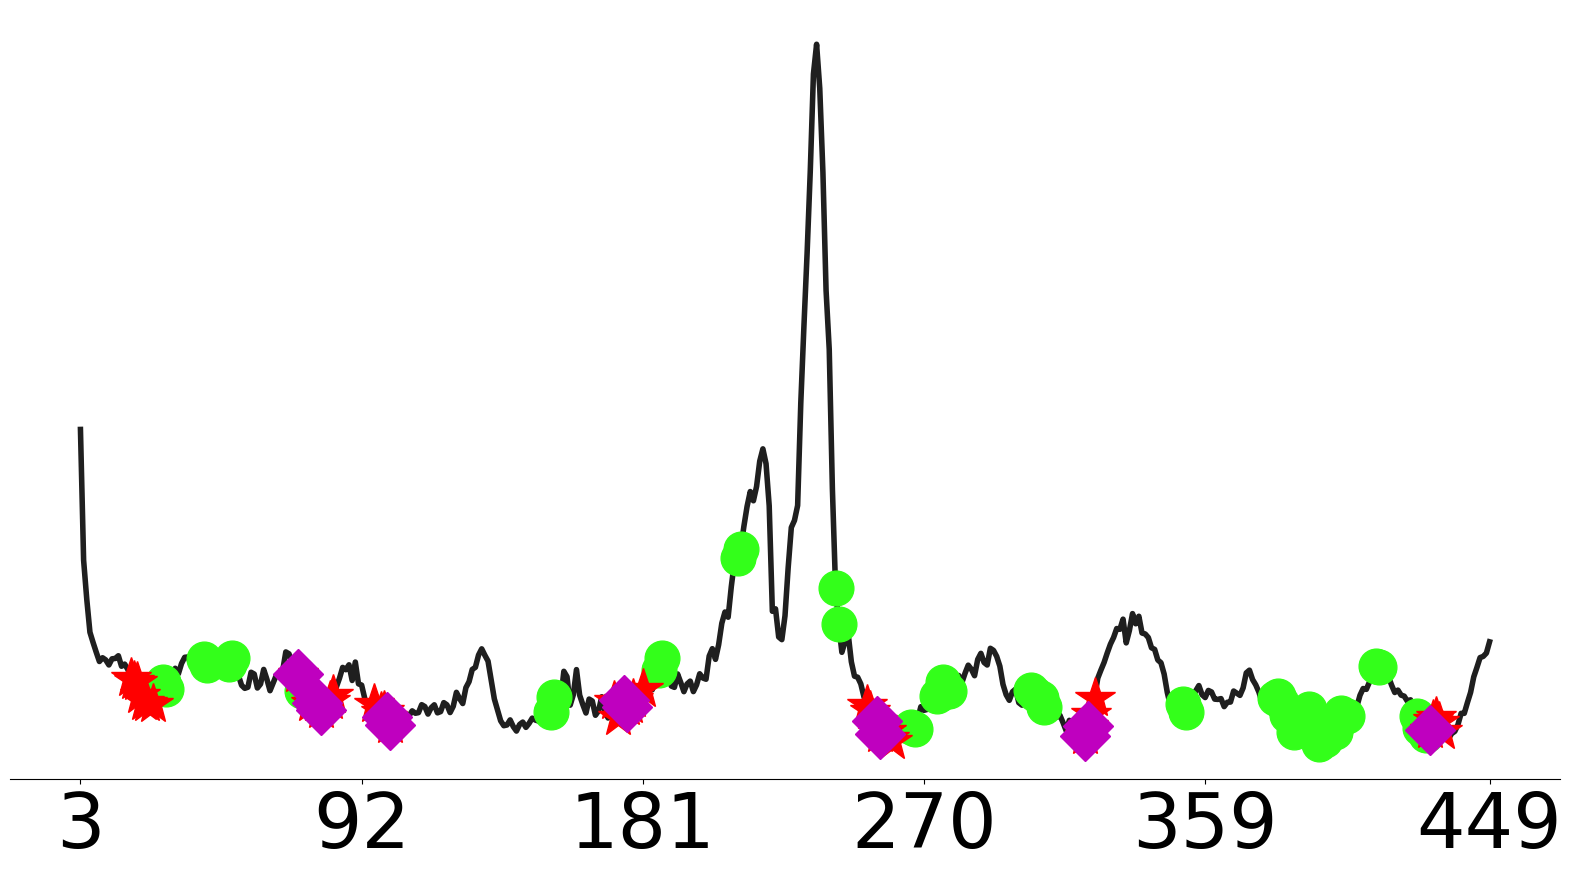

In [256]:
fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
plt.sca(ax)  # Set current axis to 'ax'
    
# Increase font sizes
plt.rc('xtick', labelsize=55)
plt.rc('ytick', labelsize=50)
plt.rcParams.update({'font.size': 70})

# calcMSF
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row): # 279
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / AverageEigVals1[mode]
    MSF.append(currMSF)

# plt.plot(MSF, color='#3B9EFF', linewidth=3, alpha=0.7)
plt.plot(MSF, color='black', linewidth=4, alpha=0.88)

HingeY = [MSF[item] for item in currHinge]
plt.plot(currHinge, HingeY, color=(0.2, 1, 0.1), marker='o', linestyle='', markersize=25)
print ('# of hinges', len(HingeY))

# plot binding sites
bindingY = [MSF[item] for item in binding]
plt.plot(binding, bindingY, 'r*', markersize=30)
print ('# of bindings sites', len(binding))

# plot overlaps
allHinge = currHinge
overlaps = [item for item in binding if item in allHinge]
overlapsY = [MSF[item] for item in overlaps]
plt.plot(overlaps, overlapsY, 'mD', markersize=25)

print ('# of hits are', len(overlaps))

# Hide y labels
plt.gca().yaxis.set_visible(False)

# Hide top, right, and left spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


# Set x-axis labels and title with Arial font
# plt.title('Cytochrome P450 \n14Alpha-Sterol Demethylase')
plt.xticks([0, Segment, Segment*2, Segment*3, Segment*4, proteinLength - 1], Labels)

plt.savefig('./CYP51_MSF.png', dpi=500)

In [257]:
AverageEigVals1

sdarray([ 0.49098313,  0.66387865,  1.33021709,  1.50884232,  1.64501765,
          1.7947583 ,  2.1205254 ,  2.55088156,  2.57597825,  2.73913075,
          2.8919443 ,  3.20237273,  3.75429484,  3.89571355,  4.28672857,
          4.4530947 ,  4.56264279,  4.74091322,  5.25821853,  5.38528867,
          5.56202117,  5.65128529,  5.75878633,  6.08643516,  6.17909723,
          6.36831443,  6.70332257,  6.94418985,  7.04954747,  7.17887507,
          7.28805946,  7.33252641,  7.69735322,  7.78638527,  7.90687137,
          7.94933117,  8.        ,  8.        ,  8.02044298,  8.12909987,
          8.25644564,  8.3533716 ,  8.40215875,  8.54182156,  8.59689444,
          8.87633511,  9.        ,  9.03084705,  9.11612977,  9.15450721,
          9.21370809,  9.26944046,  9.50629987,  9.5163359 ,  9.57717166,
          9.80327162,  9.85600141,  9.90887262,  9.95686337, 10.05152963,
         10.09273037, 10.22385313, 10.31857146, 10.36767874, 10.49509171,
         10.53498303, 10.6707602 , 10.

## write data

In [271]:
# write MSFs
# averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / EigVals[mode]
    MSF.append(currMSF)

In [272]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [273]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [277]:
row, col = averageEigVects.shape
hinges = [Hinge0, Hinge1, Hinge2]
for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 446]], 15)
    
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

writeAllData('./Data/CYP51_Method2.txt', curr)

In [275]:
currHinge = getHinges_modes2(averageEigVects, 1, bandWidth=15)
sort(currHinge)

array([ 97,  98, 149, 150, 252, 253, 318, 319, 349, 350, 378, 379, 380,
       382, 384, 385, 389, 390, 426, 427])

In [276]:
averageEigVects[426:428,1]

array([ 0.00048026, -0.00950974])

# method3

In [142]:
currNumModes = 3

In [146]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1, Hinge2], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [Hinge0, Hinge1, Hinge2], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [183]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [[], [], []], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [[], [], []], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [184]:
Hinges_2 = filterTwoEnds(Hinges_2, [[0, 446]], 15)
Hinges_3 = filterTwoEnds(Hinges_3, [[0, 446]], 15)
Hinges_4 = filterTwoEnds(Hinges_4, [[0, 446]], 15)
Hinges_5 = filterTwoEnds(Hinges_5, [[0, 446]], 15)

In [185]:
protein_length = 447

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 42
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 77 12 0.0389043117214104
# of hinge sites for first 3 modes, overlap, hyper score 75 12 0.03199038023868217
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 77 12 0.0389043117214104
# of hinge sites for first 3 modes, overlap, hyper score 76 12 0.03532290322854825


In [1263]:
print(sort(Hinges_5))

[ 30  31  32  33  34  43  44  62  63  70  72  73  74  75  76 110 113 114
 116 118 119 125 126 136 137 139 141 142 149 150 163 164 167 168 194 195
 196 199 200 201]


### write hinges

In [156]:
# write MSFs
# averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / EigVals[mode]
    MSF.append(currMSF)

In [157]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [161]:
row, col = averageEigVects.shape
hinges = [Hinge0, Hinge1, Hinge2]
for mode in modes:
    currHinge = getHinges_modes3(averageEigVects, mode, hinges[mode], bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 446]], 15)
    
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

writeAllData('./Data/CYP51_Method2_similar.txt', curr)

# Plot graph

In [213]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


# Plot single graph

In [258]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 446]], 15)
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge, len(currHinge))
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./CYP51_similar_merging_method2_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [423, 392, 393, 424, 75, 172, 76, 173, 271, 272, 273, 302, 275, 305, 304, 301, 183, 184] 18
local loop motion []
current bindings are [16, 17, 18, 19, 20, 21, 23, 69, 73, 75, 76, 79, 80, 93, 95, 96, 97, 98, 169, 170, 172, 173, 174, 175, 178, 249, 250, 252, 253, 254, 255, 256, 257, 318, 319, 320, 321, 427, 428, 429, 430, 431]
current hits are [75, 76, 172, 173]
# of overlaps finding from current mode is 4


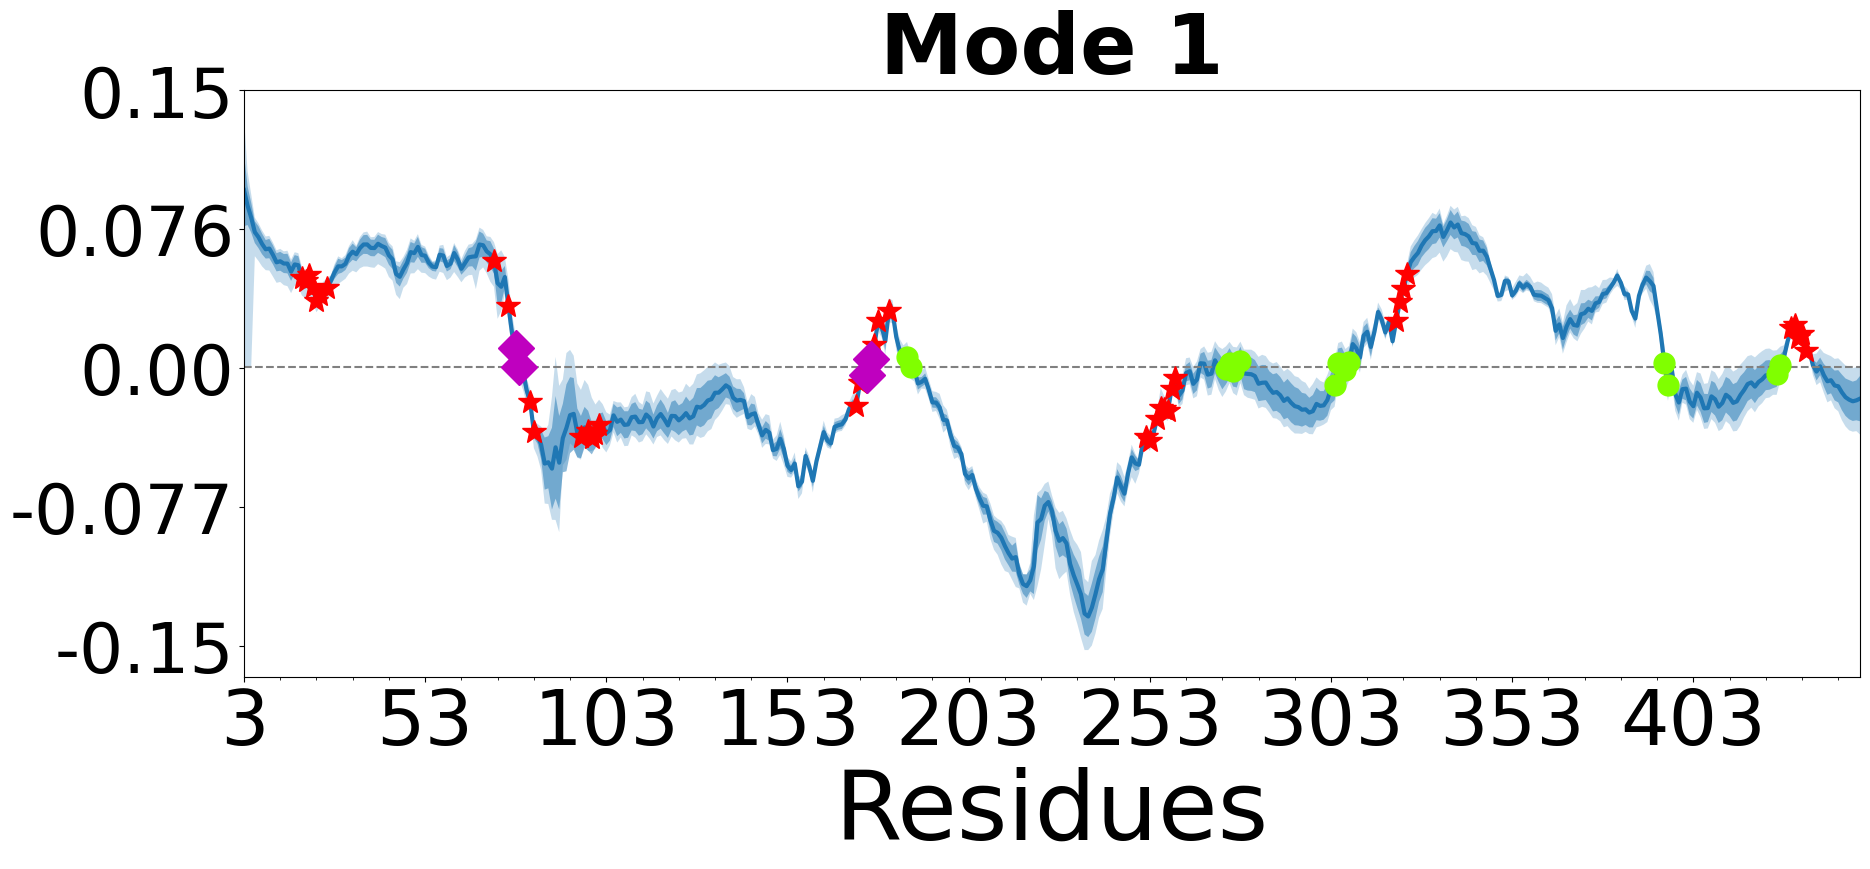

In [259]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

In [263]:
averageEigVects[425:428, 1]

array([ 0.02324719,  0.00048026, -0.00950974])

Hinge residue with wide bands [384, 385, 389, 390, 149, 150, 426, 427, 318, 319, 349, 350, 97, 98, 252, 378, 379, 380, 253, 382] 20
local loop motion []
current bindings are [16, 17, 18, 19, 20, 21, 23, 69, 73, 75, 76, 79, 80, 93, 95, 96, 97, 98, 169, 170, 172, 173, 174, 175, 178, 249, 250, 252, 253, 254, 255, 256, 257, 318, 319, 320, 321, 427, 428, 429, 430, 431]
current hits are [97, 98, 252, 253, 318, 319, 427]
# of overlaps finding from current mode is 7


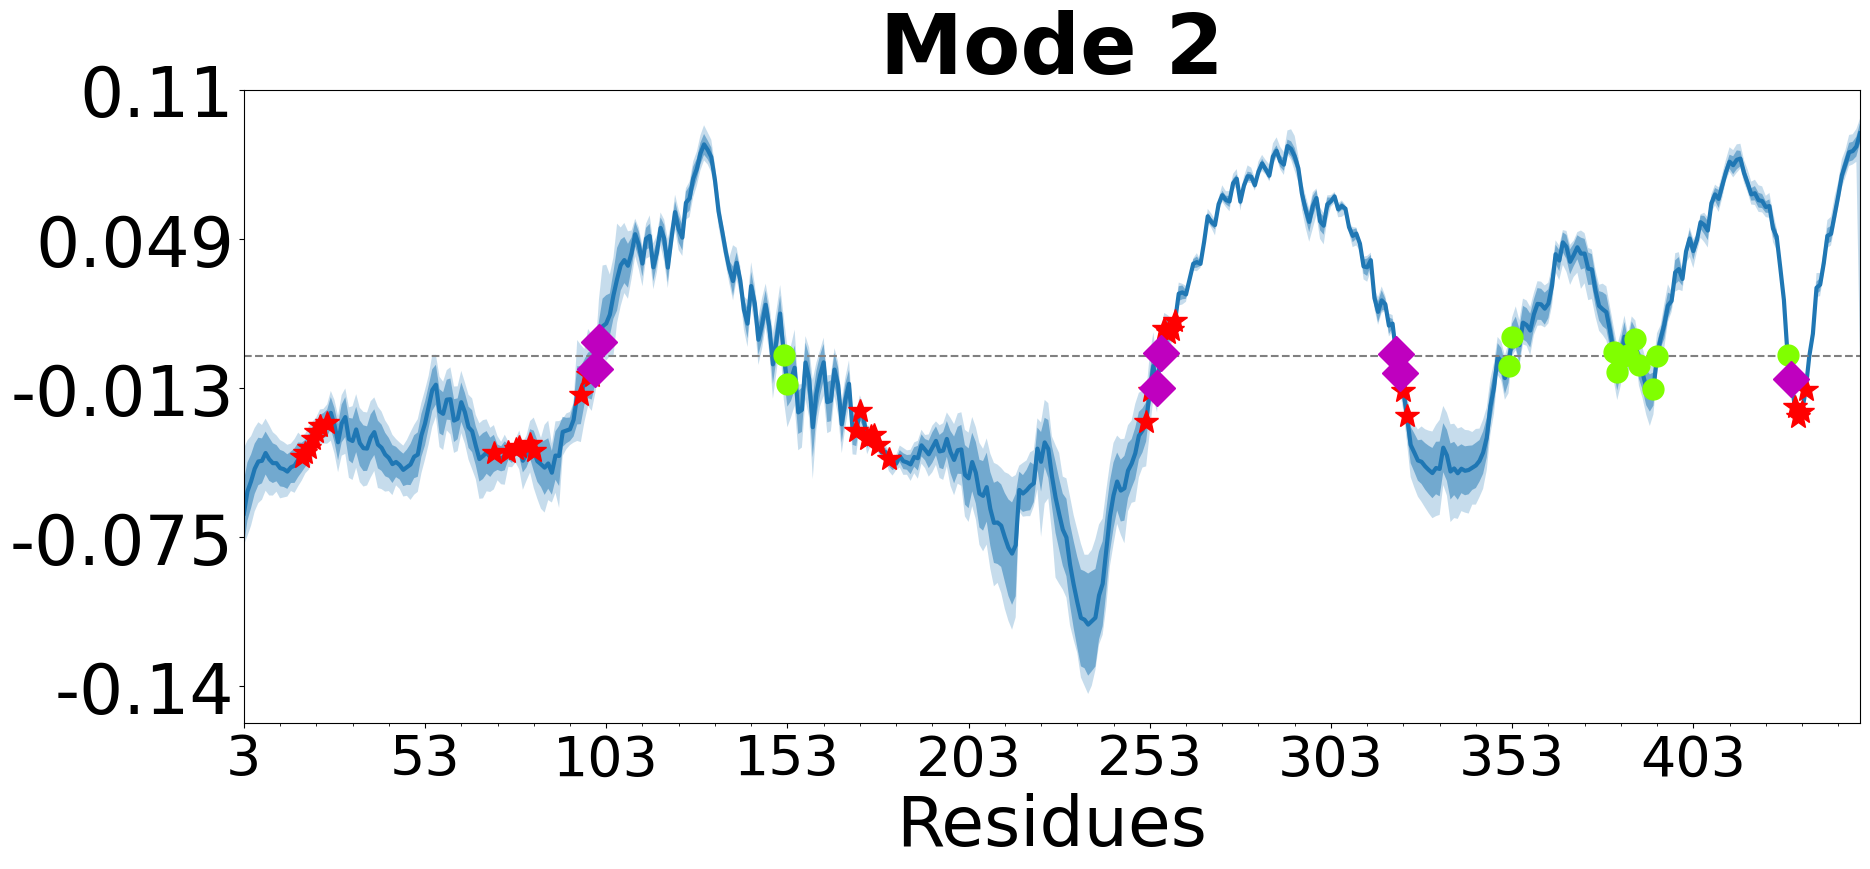

In [260]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [263, 264, 393, 392, 395, 394, 398, 399, 400, 401, 403, 404, 26, 27, 411, 413, 414, 410, 39, 40, 47, 48, 69, 70, 208, 209, 239, 240] 28
local loop motion []
current bindings are [16, 17, 18, 19, 20, 21, 23, 69, 73, 75, 76, 79, 80, 93, 95, 96, 97, 98, 169, 170, 172, 173, 174, 175, 178, 249, 250, 252, 253, 254, 255, 256, 257, 318, 319, 320, 321, 427, 428, 429, 430, 431]
current hits are [69]
# of overlaps finding from current mode is 1


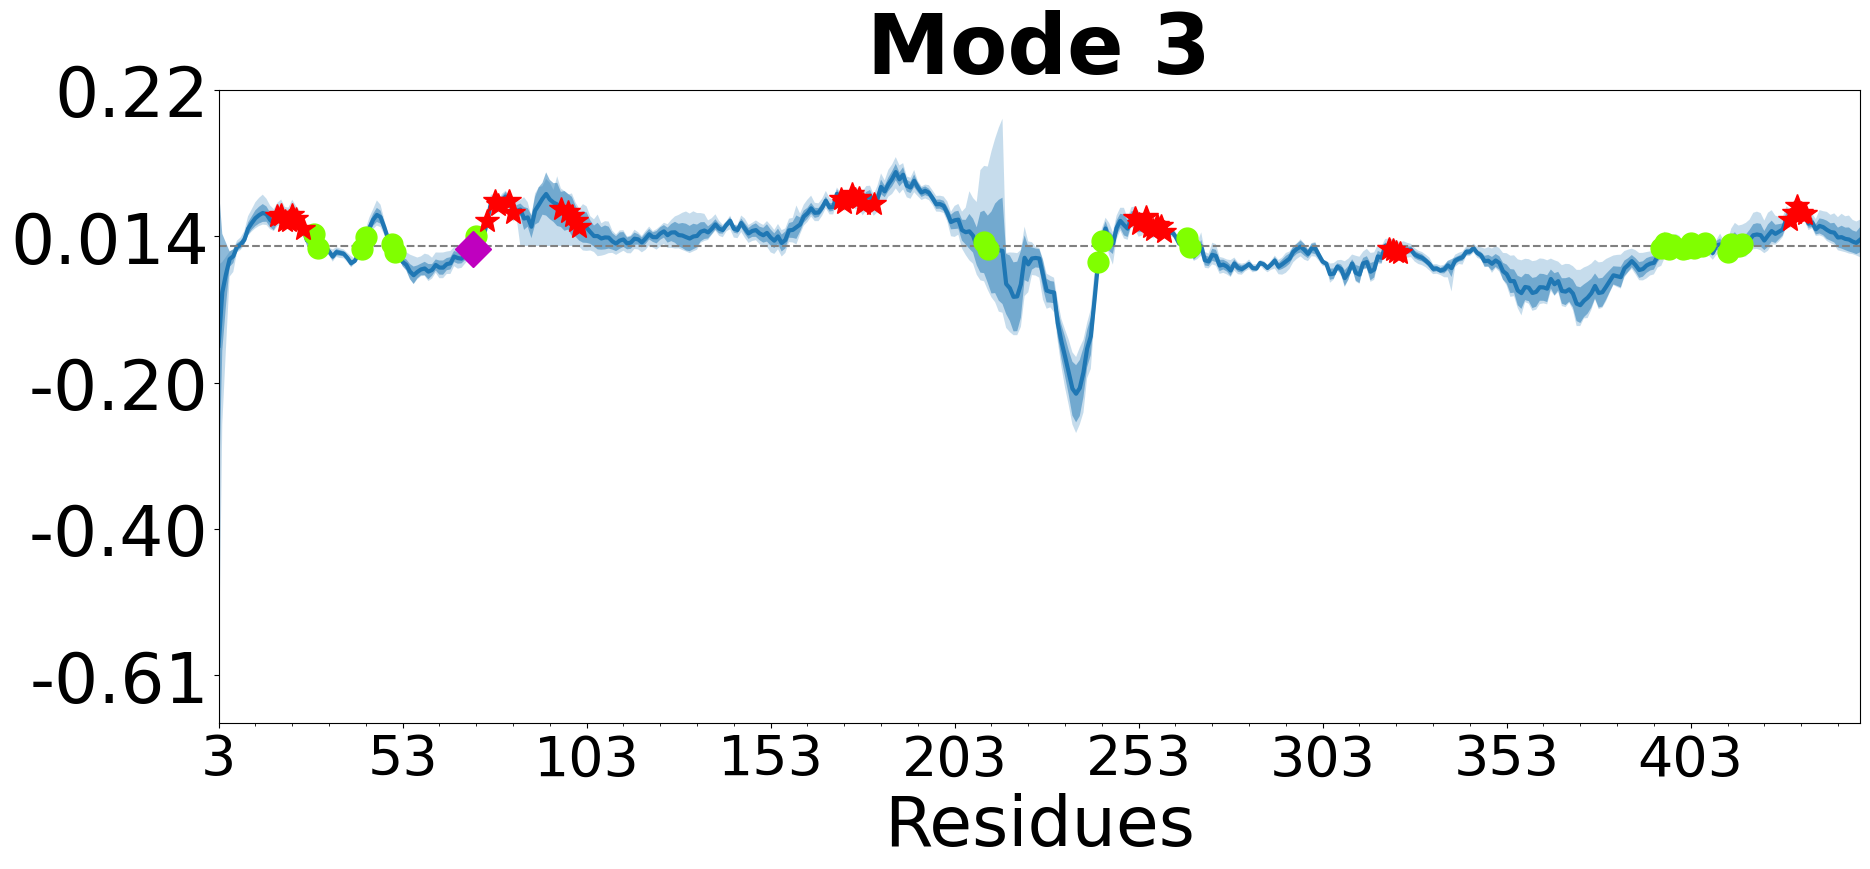

In [261]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

In [178]:
def plotSingleGraph_method3(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(20, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method3
    currHinge = getHinges_modes3(averageEigVects, mode, Hinge, bandWidth = 15)
    currHinge = filterTwoEnds(currHinge, [[0, 446]], 15)
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge)
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    # updateHinge = [item for item in Hinge if item not in currHinge]
    # HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    # print ('local loop motion', updateHinge)
    # plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./CYP51_similar_merging_method2_mode' + str(mode + 1) + '.png', dpi=500)

In [179]:
Hinge0

[76, 173, 184, 260, 261, 263, 282, 301, 392, 394, 419, 436]

Hinge residue with wide bands [391, 392, 424, 425, 75, 172, 76, 173, 365, 366, 369, 367, 181, 182, 310, 309, 311]
current bindings are [16, 17, 18, 19, 20, 21, 23, 69, 73, 75, 76, 79, 80, 93, 95, 96, 97, 98, 169, 170, 172, 173, 174, 175, 178, 249, 250, 252, 253, 254, 255, 256, 257, 318, 319, 320, 321, 427, 428, 429, 430, 431]
current hits are [75, 76, 172, 173]
# of overlaps finding from current mode is 4


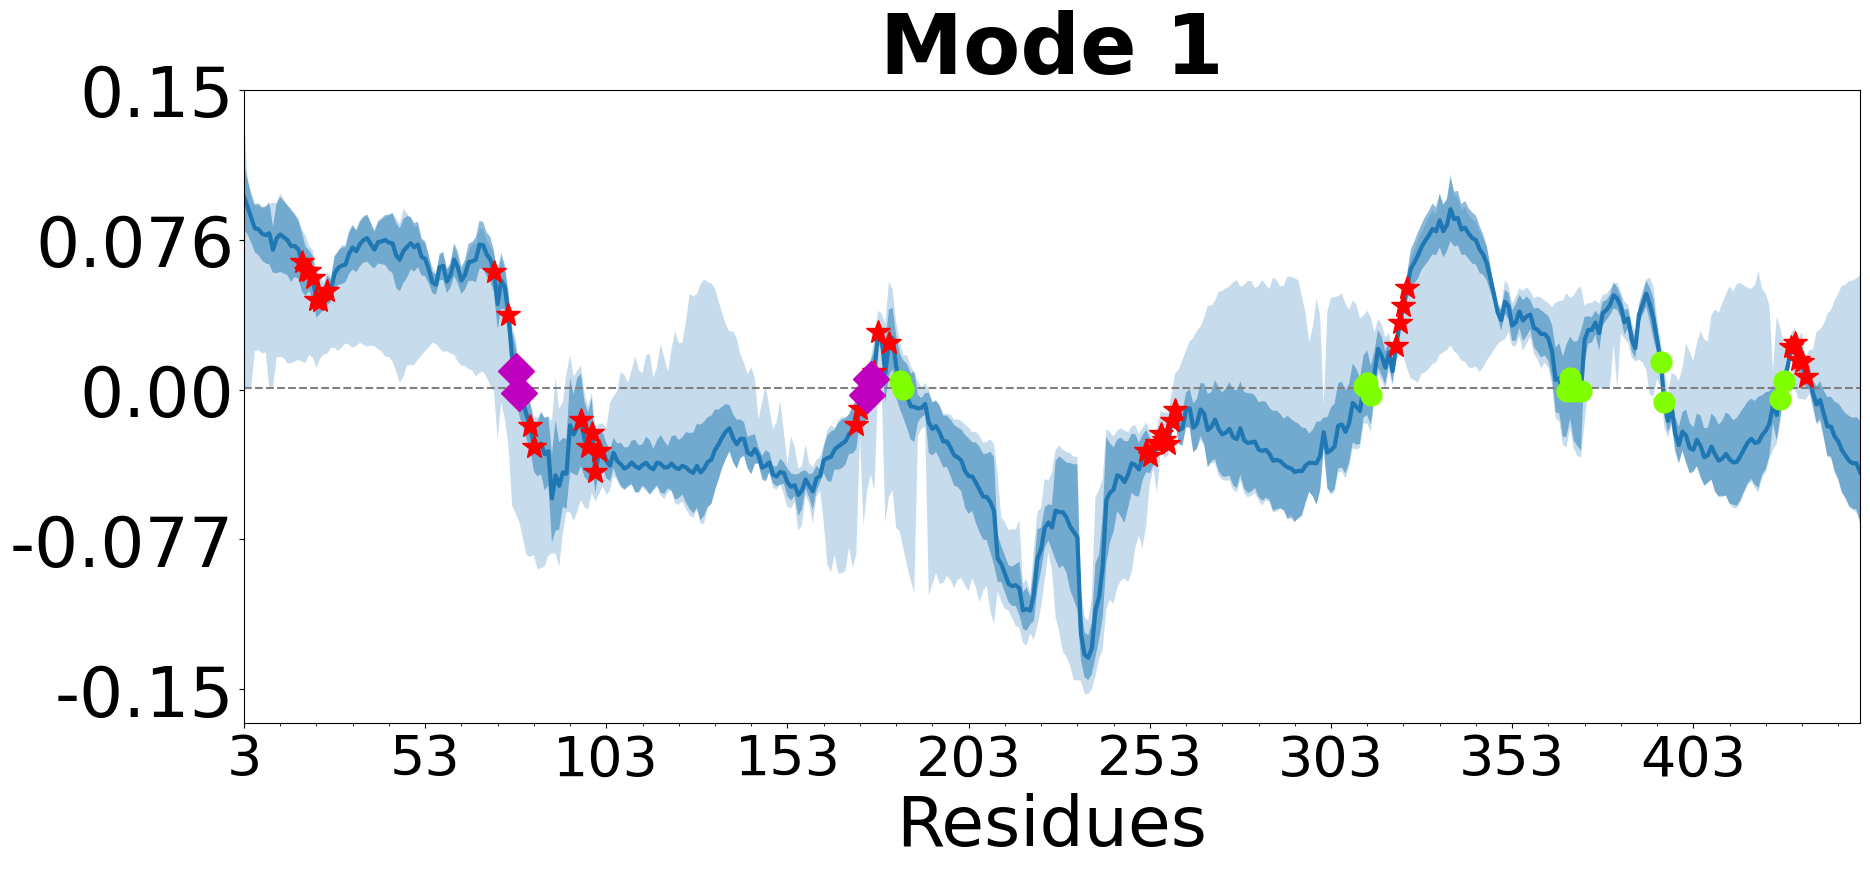

In [180]:
modes = 0 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [386, 387, 390, 142, 143, 145, 147, 427, 428, 431, 51, 52, 54, 320, 321, 344, 345, 100, 101, 254, 255]
current bindings are [16, 17, 18, 19, 20, 21, 23, 69, 73, 75, 76, 79, 80, 93, 95, 96, 97, 98, 169, 170, 172, 173, 174, 175, 178, 249, 250, 252, 253, 254, 255, 256, 257, 318, 319, 320, 321, 427, 428, 429, 430, 431]
current hits are [254, 255, 320, 321, 427, 428, 431]
# of overlaps finding from current mode is 7


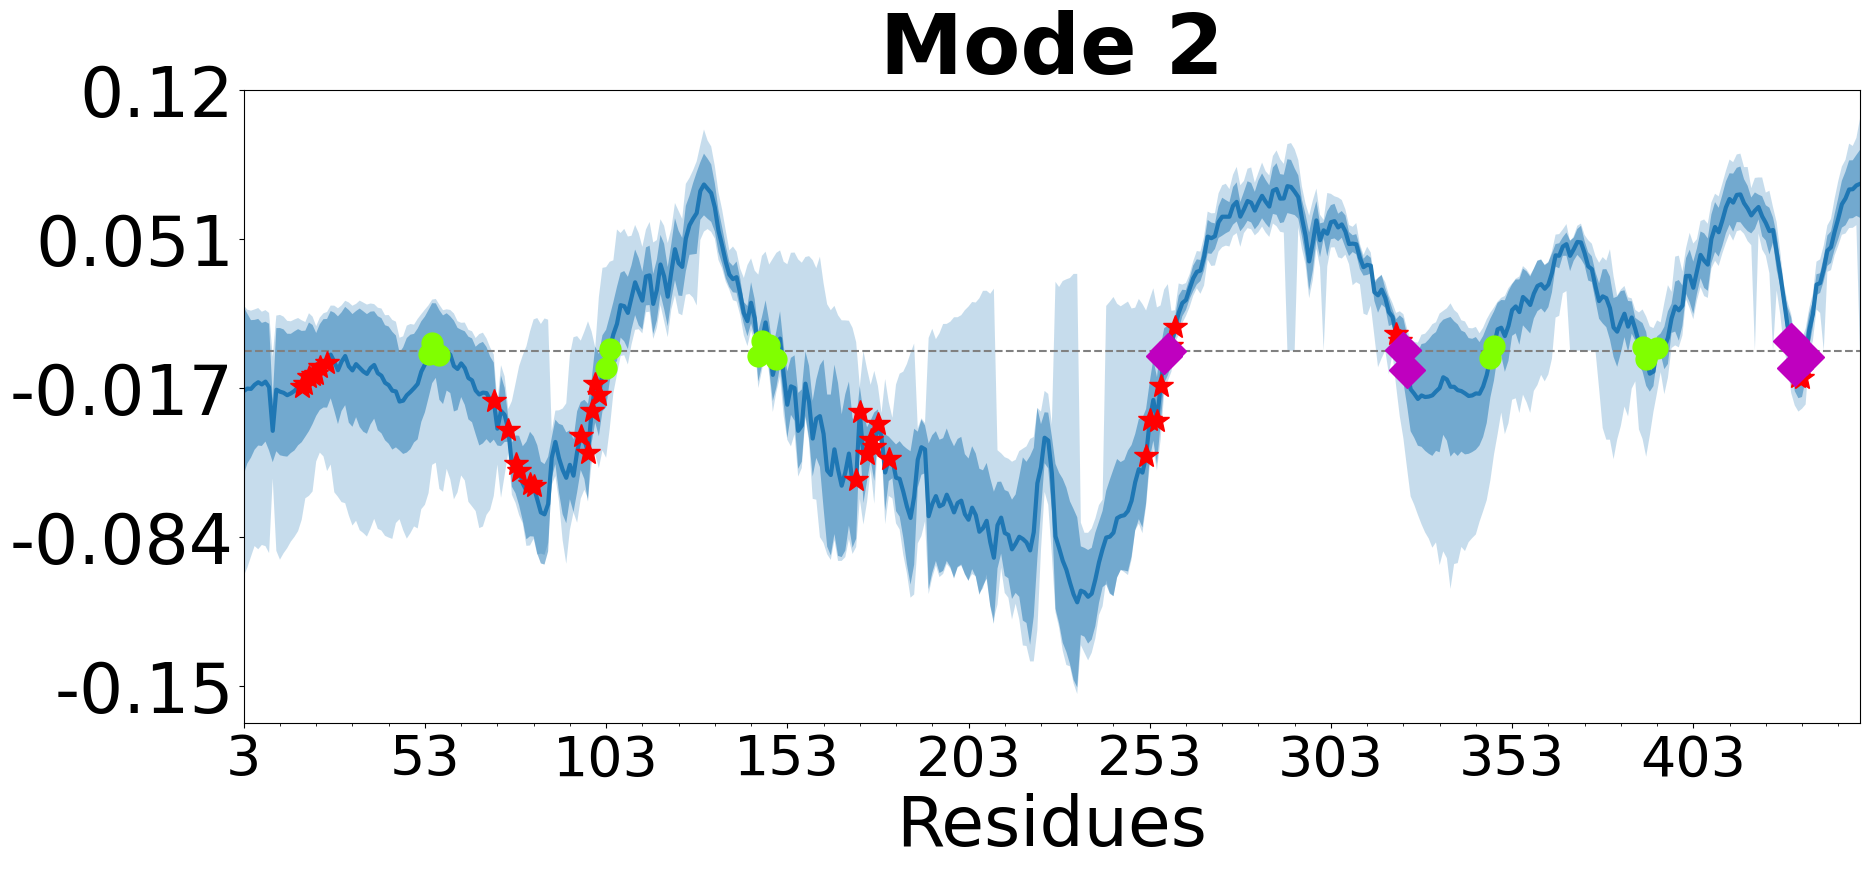

In [181]:
modes = 1 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [132, 133, 262, 263, 390, 391, 407, 24, 153, 154, 155, 25, 26, 284, 285, 283, 408, 421, 39, 40, 423, 298, 424, 300, 301, 46, 47, 317, 318, 67, 68, 323, 325, 201, 202, 340, 341, 244, 245, 123, 124, 125]
current bindings are [16, 17, 18, 19, 20, 21, 23, 69, 73, 75, 76, 79, 80, 93, 95, 96, 97, 98, 169, 170, 172, 173, 174, 175, 178, 249, 250, 252, 253, 254, 255, 256, 257, 318, 319, 320, 321, 427, 428, 429, 430, 431]
current hits are [318]
# of overlaps finding from current mode is 1


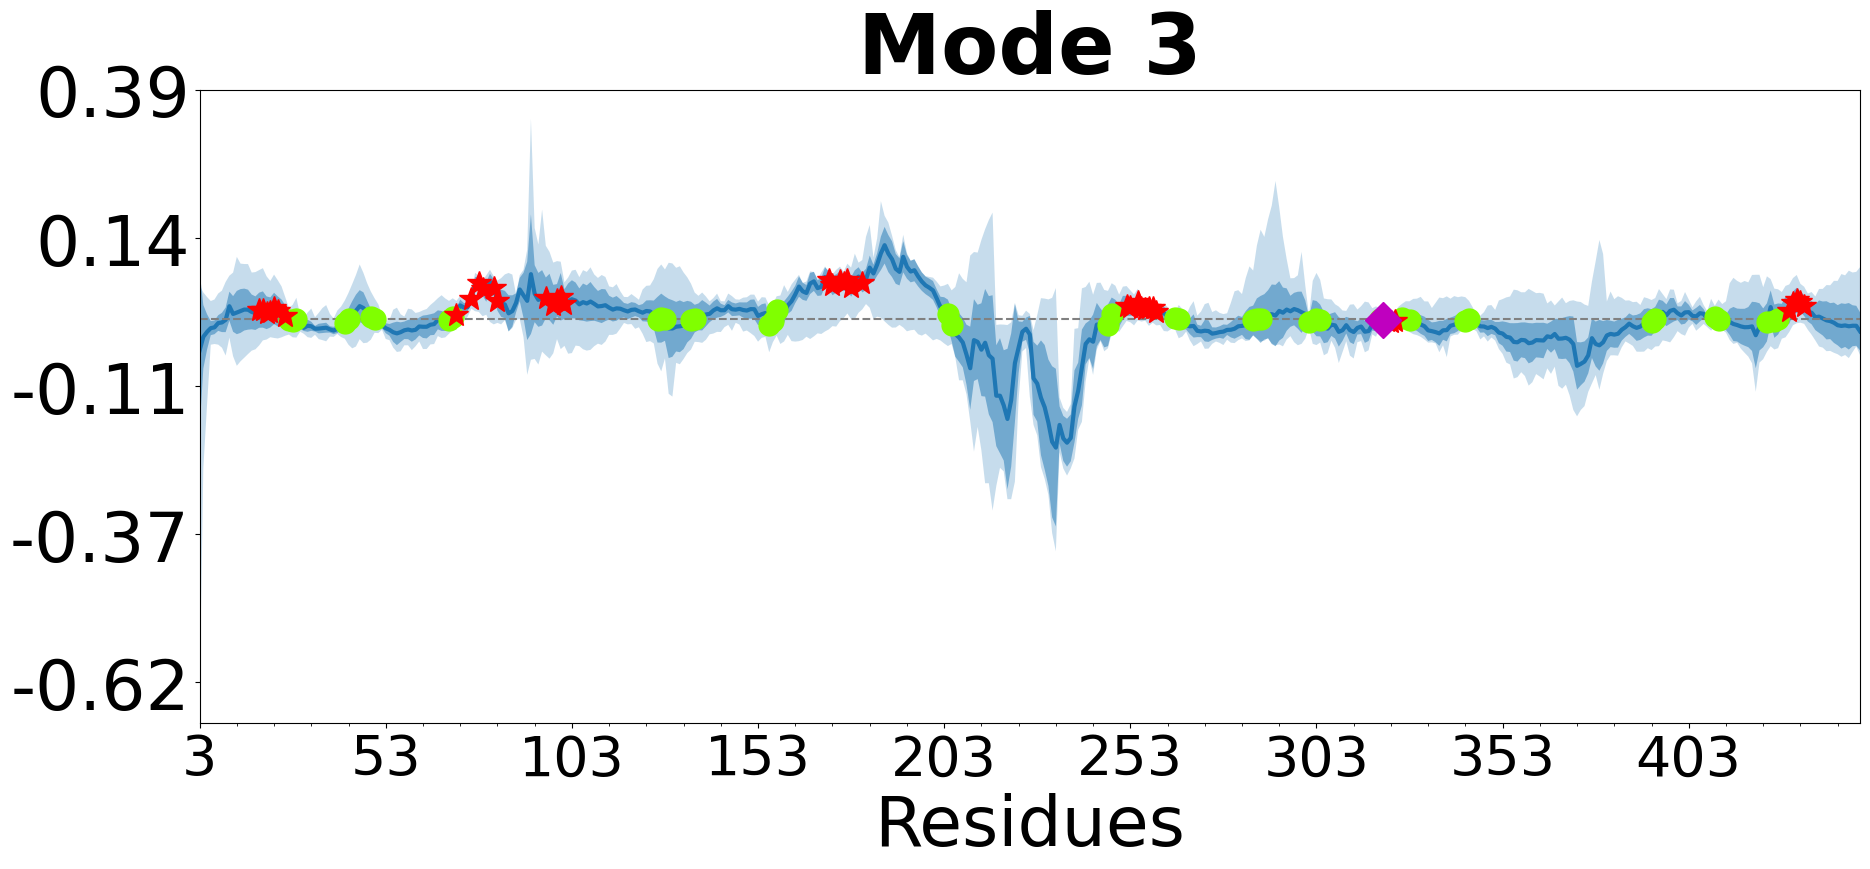

In [182]:
modes = 2 # Example modes
plotSingleGraph_method3(modes, averageEigVects, gnms, binding, [])

In [1174]:
ORA(36, 247, 45, 14)

0.0012366703910227095

# Write Modes

In [222]:
len(averageEigVects[:, 0])

447

In [231]:
mode = 2

In [232]:
residue = []
new_b_factor = []

for item in averageEigVects[:, mode]:
    new_b_factor.append(item)


In [233]:
resiIndex = [x for x in range(3, 450)]
chain = ['A' for x in range(3, 450)]
    

In [234]:
with open('./structure_demo/CYP51_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
    for i in range(len(resiIndex)):
        # print (chain[i])
        wf.write(chain[i] + ', ' + str(resiIndex[i]) + ', ' + str(new_b_factor[i]) + '\n')